# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [8]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [9]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [10]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [11]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [12]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [13]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [14]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [19]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [18]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [20]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [174]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [76]:
df_wine.head()
df_wine.loc[0]

fixed acidity            7.4000
volatile acidity         0.7000
citric acid              0.0000
residual sugar           1.9000
chlorides                0.0760
free sulfur dioxide     11.0000
total sulfur dioxide    34.0000
density                  0.9978
pH                       3.5100
sulphates                0.5600
alcohol                  9.4000
quality_cat              0.0000
Name: 0, dtype: float64

Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [4]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [5]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

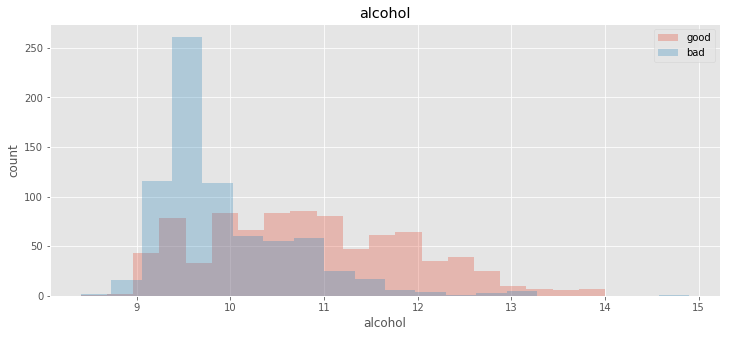

In [27]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучать классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [31]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [33]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [34]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [35]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [36]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [37]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [38]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [115]:
from sklearn.base import ClusterMixin, BaseEstimator
from numpy.linalg import norm
from sklearn.metrics.pairwise import distance_metrics
import copy

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        try:
            X = np.array(X)
        except:
            raise TypeError('Need pd.DataFrame or np.array')
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0]).astype(int)
        new_labels = np.empty(X.shape[0]).astype(int)
        
        # Массив с центроидами кластеров, заполняем случайными числами в соответствии с диапазоном входных данных
        self.centroids = np.empty((self.k, X.shape[1]))
        new_centroids = np.empty((self.k, X.shape[1]))
        for i in xrange(X.shape[1]):
            min = X[:,i].min()
            max = X[:,i].max()
            self.centroids[:, i] = min + np.random.random(self.k)*(max-min)
        
        ## Your Code Here
                
        for it in xrange(self.max_iter):
            
            #заполняем new_labels - ближайший центроид для каждого объекта
            new_labels = distance_metrics()[self.metric](self.centroids, X).argmin(axis=0)
                        
            #считаем новые координаты центроидов
            for cen in xrange(self.k):
                new_centroids[cen] = np.average(X[self.labels == cen], axis=0)
            
            #если нет ни одной точки в кластере, снова случайно выставляем этот центроид
            empty_clusters = np.argwhere(np.isnan(new_centroids).any(axis=1))
            new_centroids[empty_clusters] = self.centroids[empty_clusters]         
            
            #если среднее смещение центроида меньше eps, то заканчиваем
            #delta = float(np.trace(distance_metrics()[self.metric](self.centroids, new_centroids))/self.k)
            #eps = 0.001
            #if delta < eps:
            
            #если ни один объект не поменял свой кластер, то заканчиваем
            if np.array_equal(new_labels, self.labels):
                self.centroids = copy.deepcopy(new_centroids)
                self.labels = copy.deepcopy(new_labels)
                #print 'iterations = ', it
                break
            
            self.centroids = copy.deepcopy(new_centroids)
            self.labels = copy.deepcopy(new_labels)

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        try:
            X = np.array(X)
        except:
            raise TypeError('Need pd.DataFrame or np.array')
        
        return distance_metrics()[self.metric](self.centroids, X).argmin(axis=0)


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [85]:
from sklearn.datasets import make_blobs

In [181]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

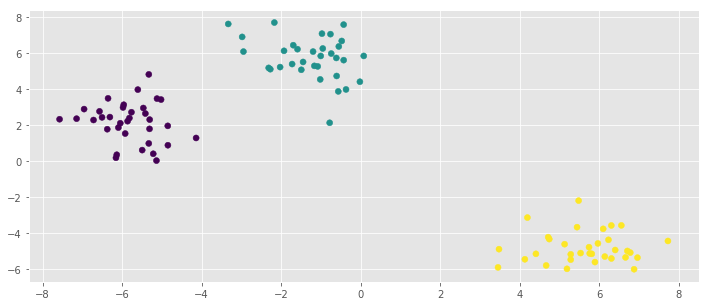

In [182]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

iterations =  3
[[ 4.23148379  1.2463483 ]
 [ 0.33827828 -7.87588794]
 [-4.00959202  5.55980322]]


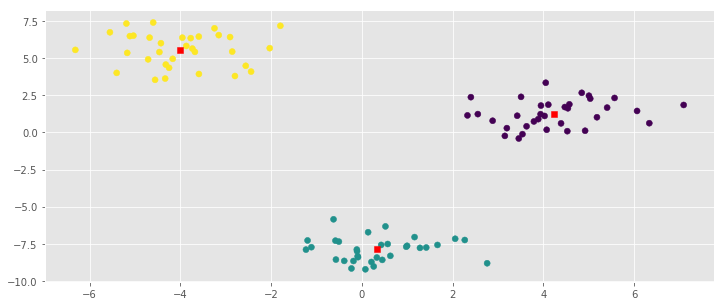

In [86]:
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=98)
df = pd.DataFrame(X)
t = Kmeans(k = 3, random_state=51)
k_means = t.fit(df)

print k_means.centroids
plt.scatter(df[0], df[1], c=t.labels)
plt.scatter(x=k_means.centroids[:,0], y=k_means.centroids[:,1], color='red', marker='s')

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [87]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()
#print len(df_sns)

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [88]:
## Your Code Here
#отделяем ненужные признаки
trash, data = df_sns.iloc[:, :4], df_sns.iloc[:, 4:]
df = pd.DataFrame(data)

#нормализация
df_norm = (df - df.mean()).div(df.std())
df_norm.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


Разбиение по кластерам зависит от начального положения центроидов, которые выставляются случайным образом. Поэтому подберем random_state, при котором разбиение будет более адекватным - более равномерное распределение между кластерами. Для этого запустим алгоритм с различными значениями random_state от 0 до 1000 и выберем такие, при которых получается наименьшее количество пустых кластеров.

In [127]:
f = open('random_state.txt', 'w')
buf = ''

for rs in xrange(1000):
    buf += str(rs) + '\n'
    t = Kmeans(k=9, random_state=rs, max_iter=50)
    k_means = t.fit(df_norm)
    arr = np.zeros(9).astype(int)
    for i in xrange(k_means.labels.shape[0]):
        arr[k_means.labels[i]] += 1

    
    if len(arr[arr==0]) <= 2:
        buf += 'END len = {0}    rs = {1}\n'.format(len(arr[arr==0]), rs)
        
f.write(buf)

Запускаем алгоритм

In [130]:
t = Kmeans(k=9, random_state=322)
k_means = t.fit(df_norm)

Для каждого кластера выведем наиболее популярные слова (максимальное среднее значение координаты), а также средний возраст и среднее количество друзей.

In [131]:
df_norm['cluster'] = pd.DataFrame(k_means.labels)  #таблица с ключевыми словами
trash['cluster'] = pd.DataFrame(k_means.labels)  #таблица с возрастом, друзьями

for i in xrange(k_means.k):
    df_tmp = df_norm.loc[df_norm['cluster'] == i]
    df_tmp = df_tmp.drop('cluster', 1)
    df_tmp_trash = trash.loc[trash['cluster'] == i]
    df_tmp_trash = df_tmp_trash.drop('cluster', 1)
    if len(df_tmp) != 0:
        print '####################################\nCluster {0}\n'.format(i+1)
        print 'People in cluster: {0}\n\n'.format(len(df_tmp))
        print df_tmp_trash.mean()
        print '\n\n'
        print df_tmp.mean().sort_values(ascending=False)[:5]
        print '\n'

####################################
Cluster 1

People in cluster: 20325


gradyear    2007.427454
age           18.181762
friends       27.587995
dtype: float64



blonde   -0.028974
tennis   -0.049780
jesus    -0.073732
death    -0.077923
drunk    -0.084431
dtype: float64


####################################
Cluster 2

People in cluster: 810


gradyear    2007.846914
age           17.518681
friends       41.158025
dtype: float64



hollister      4.177444
abercrombie    4.056507
shopping       0.765343
mall           0.515528
clothes        0.511221
dtype: float64


####################################
Cluster 3

People in cluster: 762


gradyear    2007.598425
age           17.672111
friends       34.045932
dtype: float64



dance     4.055874
dress     0.234891
music     0.127602
rock      0.090322
church    0.048616
dtype: float64


####################################
Cluster 4

People in cluster: 1002


gradyear    2007.598802
age           17.599788
friends       30.733533
dt

Получилось 9 кластеров, разбитых по интересам:<br>
1) Без ярко выраженных интересов, самая большая группа. Можно сказать, серая масса. Наиболее заметные интересы - блондинки, теннис, религия. Что характерно, в среднем у них меньше всего друзей.<br>
2) Hollister и Abercrombie - марки одежды. Кластер их фанатов. Самая общительная группа - больше всего друзей в среднем.<br>
3) Танцы<br>
4) Тусовки, кутеж<br>
5) Волейбол, а также немного другие игровые виды спорта. В среднем много друзей.<br>
6) Бейсбол, футбол, баскетбол<br>
7) Религия<br>
8) Софтбол - разовидность бейсбола. Тоже достаточно общительная группа.<br>
9) Шоппинг, одежда, красота<br><br>
Средний возраст во всех группах одинаковый - 17-18 лет.